## Import

In [51]:
!pip install xgboost
!pip install lightgbm


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Calcolo partite lunghe

In [53]:
def calcola_partite_lunghe(df, n=12):
    """
    Calcola il numero di partite "lunghe" (>20 giochi) giocate da ciascun giocatore negli ultimi n mesi.
    """
    # Assicura che la colonna 'Date' sia in formato datetime 
    df['Date'] = pd.to_datetime(df['Date'])
    cutoff_date = df['Date'].max() - pd.DateOffset(months=n)
    
    # Calcola il numero totale di giochi per ogni partita
    df['total_games'] = df['Score'].apply(
        lambda score: sum([int(x.split('-')[0]) + int(x.split('-')[1]) for x in score.split() if '-' in x])
    )
    
    # Filtra solo le partite lunghe
    long_matches = df[(df['total_games'] > 20) & (df['Date'] >= cutoff_date)]
    
    # Conta le partite lunghe per ogni giocatore
    long_matches_p1 = long_matches.groupby('P1_name').size()
    long_matches_p2 = long_matches.groupby('P2_name').size()
    
    # Combina i risultati in un dizionario
    partite_lunghe = long_matches_p1.add(long_matches_p2, fill_value=0).to_dict()
    
    # Aggiungi valori di default per tutti i giocatori
    all_players = pd.concat([df['P1_name'], df['P2_name']]).unique()
    partite_lunghe_full = {player: partite_lunghe.get(player, 0) for player in all_players}
    
    return partite_lunghe_full


# Calcolo H2H tra due giocatori

In [54]:
from collections import defaultdict

def calcola_h2h(df):
    """
    Calcola lo storico Head-to-Head (H2H) tra i giocatori per ciascuna partita.
    
    Parameters:
        df (DataFrame): Dataset ordinato cronologicamente con le colonne "P1_name", "P2_name" e "Winner".
        
    Returns:
        DataFrame: Due colonne "H2H_p1" e "H2H_p2" con il numero di vittorie di ciascun giocatore contro l'altro.
    """
    # Dizionario per tracciare lo storico H2H tra i giocatori
    h2h = defaultdict(lambda: {'p1_wins': 0, 'p2_wins': 0})
    
    # Liste per le colonne H2H da aggiungere
    h2h_p1 = []
    h2h_p2 = []

    # Itera sulle partite
    for _, row in df.iterrows():
        p1, p2, winner = row["P1_name"], row["P2_name"], row["Winner"]
        
        # Recupera lo storico H2H corrente
        h2h_current = h2h[(p1, p2)]
        
        # Aggiunge lo storico prima della partita corrente
        h2h_p1.append(h2h_current['p1_wins'])
        h2h_p2.append(h2h_current['p2_wins'])
        
        # Aggiorna lo storico in base al vincitore
        if winner == p1:
            h2h[(p1, p2)]['p1_wins'] += 1
        elif winner == p2:
            h2h[(p1, p2)]['p2_wins'] += 1

    # Aggiunge le colonne al dataframe
    df["H2H_p1"] = h2h_p1
    df["H2H_p2"] = h2h_p2
    
    return df

# Funzione probabilità terzo set in base al ranking

In [55]:
def calcola_probabilità_giocatori(df, n_bins):
    """
    Calcola per ogni giocatore la probabilità aggregata di andare al terzo set
    in base al ranking medio degli avversari nelle partite passate.

    Parameters:
        df (DataFrame): Il DataFrame contenente i dati delle partite.
        n_bins (int): Numero di intervalli per suddividere i ranking.

    Returns:
        dict: Un dizionario con i giocatori come chiavi e le probabilità di andare al terzo set.
    """
    # Calcolo della media del ranking degli avversari e probabilità di terzo set
    prob_terzo_set = {}

    # Per ogni giocatore come Player 1
    for player in df['P1_name'].unique():
        player_data = df[df['P1_name'] == player]
        if len(player_data) > 0:
            avg_rank_opponent = player_data['ATP_rank_p2'].mean()
            prob_set_3 = player_data['target_sets'].mean()
            prob_terzo_set[player] = (avg_rank_opponent, prob_set_3)

    # Per ogni giocatore come Player 2
    for player in df['P2_name'].unique():
        player_data = df[df['P2_name'] == player]
        if len(player_data) > 0:
            avg_rank_opponent = player_data['ATP_rank_p1'].mean()
            prob_set_3 = player_data['target_sets'].mean()
            if player in prob_terzo_set:
                # Media delle probabilità già calcolate
                prob_terzo_set[player] = (
                    (prob_terzo_set[player][0] + avg_rank_opponent) / 2,
                    (prob_terzo_set[player][1] + prob_set_3) / 2,
                )
            else:
                prob_terzo_set[player] = (avg_rank_opponent, prob_set_3)

    return prob_terzo_set


def aggiungi_probabilità_partite(df, prob_terzo_set):
    """
    Aggiunge al DataFrame la probabilità calcolata per i due giocatori di andare al terzo set.

    Parameters:
        df (DataFrame): Il DataFrame originale.
        prob_terzo_set (dict): Dizionario con le probabilità calcolate per ogni giocatore.

    Returns:
        DataFrame: Il DataFrame aggiornato con le nuove feature.
    """
    def calcola_prob_giocatore(player, prob_terzo_set):
        return prob_terzo_set.get(player, (0, 0))[1]

    # Aggiungi le nuove colonne
    df['prob_terzo_set_p1'] = df['P1_name'].map(lambda x: calcola_prob_giocatore(x, prob_terzo_set))
    df['prob_terzo_set_p2'] = df['P2_name'].map(lambda x: calcola_prob_giocatore(x, prob_terzo_set))

    return df

# Funzione per calcolo stato di forma di un giocatore

In [56]:
from collections import defaultdict

def calcola_stato_forma_debug(df, n=5):
    stato_di_forma = defaultdict(list)
    nan_count = 0  # Conta i NaN generati

    df = df.sort_values(by=["Tournament", "Date"]).reset_index(drop=True)

    for index, row in df.iterrows():
        p1, p2 = row["P1_name"], row["P2_name"]
        date = row["Date"]

        # Controlla se i giocatori e i dati chiave sono validi
        if pd.isna(p1) or pd.isna(p2) or pd.isna(row["Winner"]):
            nan_count += 1
            yield 0, 0
            continue

        # Conta le vittorie per le ultime n partite giocate da ciascun giocatore
        p1_wins = sum((x["Winner"] == p1) for x in stato_di_forma[p1][-n:])
        p2_wins = sum((x["Winner"] == p2) for x in stato_di_forma[p2][-n:])

        # Gestione di giocatori senza partite precedenti
        if len(stato_di_forma[p1]) > 0:
            p1_form = p1_wins / min(len(stato_di_forma[p1]), n)
        else:
            p1_form = 0

        if len(stato_di_forma[p2]) > 0:
            p2_form = p2_wins / min(len(stato_di_forma[p2]), n)
        else:
            p2_form = 0

        # Debug specifico
        if pd.isna(p1_form) or pd.isna(p2_form):
            print(f"DEBUG: NaN rilevato per index={index}, P1={p1}, P2={p2}")
            nan_count += 1

        # Aggiorna lo stato di forma per i giocatori
        stato_di_forma[p1].append({"Date": date, "Winner": row["Winner"]})
        stato_di_forma[p2].append({"Date": date, "Winner": row["Winner"]})

        yield p1_form, p2_form

    print(f"Totale valori NaN generati: {nan_count}")


## Funzione per contare i set

In [57]:
# Funzione per contare i set vinti
def conta_set_vinti(score, player):
    set_vinti = 0
    for set_score in score.split():
        set_p1, set_p2 = map(int, set_score.split('-'))
        if (set_p1 > set_p2 and player == 1) or (set_p2 > set_p1 and player == 2):
            set_vinti += 1
    return set_vinti

# Caricamento Dataset


In [58]:
# Carica il dataset e crea il dataframe che utilizzo per l'addestramento
print("Caricamento del dataset")
df = pd.read_csv('./atp_tennis.csv')

Caricamento del dataset


# Definizione dataframe e filtraggio

In [59]:
# Mostra le righe totali prima del filtraggio
print("\nPrima del filtraggio e pulizia:")
print(f"Righe totali: {len(df)}")

# Filtra le quote negative o nulle
df = df[(df['Odd_1'] > 0) & (df['Odd_2'] > 0)]
# Filtra i punti ATP positivi
df = df[(df['Pts_1'] > 0) & (df['Pts_2'] > 0)]

# Rimuovi righe con valori NaN in qualsiasi colonna
df = df.dropna()

# Converti la colonna Date in formato datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Rinominare le colonne
df.rename(
    columns={
        'Pts_1': 'ATP_pts_p1',
        'Pts_2': 'ATP_pts_p2',
        'Rank_1': 'ATP_rank_p1',
        'Rank_2': 'ATP_rank_p2',
        'Odd_1': 'PreMatch_Odd_p1',
        'Odd_2': 'PreMatch_Odd_p2',
        'Player_1': 'P1_name',
        'Player_2': 'P2_name',
        'Best of': 'N_sets'
    },
    inplace=True
)

# Stampa le righe totali dopo il filtraggio
print("\nDopo il filtraggio:")
print(f"Righe rimanenti: {len(df)}")

# Stampa il numero di valori mancanti per ogni colonna (dopo il filtraggio, dovrebbe essere 0)
print("\nValori nulli per colonna (dopo il filtraggio):")
print(df.isnull().sum())

# Visualizza le prime righe del DataFrame pulito
print("\nPrime righe del DataFrame pulito:")
print(df.head())




Prima del filtraggio e pulizia:
Righe totali: 64166

Dopo il filtraggio:
Righe rimanenti: 48344

Valori nulli per colonna (dopo il filtraggio):
Tournament         0
Country            0
Date               0
Series             0
Court              0
Surface            0
Round              0
N_sets             0
P1_name            0
P2_name            0
Winner             0
ATP_rank_p1        0
ATP_rank_p2        0
ATP_pts_p1         0
ATP_pts_p2         0
PreMatch_Odd_p1    0
PreMatch_Odd_p2    0
Score              0
dtype: int64

Prime righe del DataFrame pulito:
         Tournament Country       Date         Series    Court Surface  \
15652  Swedish Open  Sweden 2005-07-04  International  Outdoor    Clay   
15653  Swedish Open  Sweden 2005-07-04  International  Outdoor    Clay   
15654  Swedish Open  Sweden 2005-07-05  International  Outdoor    Clay   
15655  Swedish Open  Sweden 2005-07-05  International  Outdoor    Clay   
15656  Swedish Open  Sweden 2005-07-05  International  Outd

# Scelta colonne, aggiunta colonne e filtro 3 set

In [60]:
# Mantieni solo le colonne di interesse
columns_to_keep = [
    'ATP_rank_p1', 'ATP_rank_p2', 'ATP_pts_p1', 'ATP_pts_p2', 'Tournament', 'Court', 'Surface',
    'PreMatch_Odd_p1', 'PreMatch_Odd_p2', 'Winner', 'P1_name', 'P2_name', 'Score', 'N_sets', 'Date'
]
df = df[columns_to_keep]

# Calcola le feature derivate e garantisce valori positivi per le differenze
df['rank_diff'] = abs(df['ATP_rank_p1'] - df['ATP_rank_p2'])  # Differenza assoluta tra i rank
df['pts_ATP_diff'] = abs(df['ATP_pts_p1'] - df['ATP_pts_p2'])    # Differenza assoluta tra i punti ATP in quel giorno
df['avg_rank'] = (df['ATP_rank_p1'] + df['ATP_rank_p2']) / 2
df['Odd_diff'] = abs(df['PreMatch_Odd_p1'] - df['PreMatch_Odd_p2'])  # Differenza assoluta tra le quote pre match

# Aggiungi le colonne per i set vinti da ciascun giocatore
df["Sets_Won_Player_1"] = df["Score"].apply(lambda score: conta_set_vinti(score, 1))
df["Sets_Won_Player_2"] = df["Score"].apply(lambda score: conta_set_vinti(score, 2))
df['Total_sets_played'] = df['Sets_Won_Player_1'] + df['Sets_Won_Player_2']

# Filtra solo le righe con N_sets = 3
df = df[df['N_sets'] == 3]

# Stampa il numero di righe dopo il filtro
print("\nDopo il filtro per N_sets = 3:")
print(f"Righe rimanenti: {len(df)}")

# Visualizza le prime righe del DataFrame filtrato
print("\nPrime righe del DataFrame filtrato:")
print(df.head())


Dopo il filtro per N_sets = 3:
Righe rimanenti: 39110

Prime righe del DataFrame filtrato:
       ATP_rank_p1  ATP_rank_p2  ATP_pts_p1  ATP_pts_p2    Tournament  \
15652         20.0        112.0      1425.0       381.0  Swedish Open   
15653        132.0        917.0       326.0         9.0  Swedish Open   
15654         27.0        109.0      1200.0       391.0  Swedish Open   
15655        136.0         31.0       315.0      1150.0  Swedish Open   
15656         42.0         71.0       811.0       541.0  Swedish Open   

         Court Surface  PreMatch_Odd_p1  PreMatch_Odd_p2          Winner  ...  \
15652  Outdoor    Clay             1.10             6.00      Robredo T.  ...   
15653  Outdoor    Clay             1.66             2.10  Vinciguerra A.  ...   
15654  Outdoor    Clay             1.19             4.00      Youzhny M.  ...   
15655  Outdoor    Clay             7.00             1.07    Ferrero J.C.  ...   
15656  Outdoor    Clay             1.19             4.00      Be

# Controllo su score dei 3 set

In [61]:
# Filtra le righe incoerenti dove Total_sets_played non è 2 o 3
righe_incoerenti = df[~df['Total_sets_played'].isin([2, 3])]

# Mostra le righe incoerenti, se presenti
if not righe_incoerenti.empty:
    print("\nRighe incoerenti trovate:")
    print(righe_incoerenti[['N_sets', 'Total_sets_played', 'Score']])
else:
    print("\nNon ci sono righe incoerenti.")

# Filtra solo le righe coerenti (Total_sets_played = 2 o 3)
df = df[df['Total_sets_played'].isin([2, 3])]

# Stampa il numero di righe rimanenti e un'anteprima del DataFrame pulito
print("\nDopo il filtraggio delle righe incoerenti:")
print(f"Righe rimanenti: {len(df)}")
print(df.head())



Righe incoerenti trovate:
       N_sets  Total_sets_played                Score
18449       3                  4      4-6 4-6 6-4 5-7
21209       3                  5  4-6 4-6 7-6 6-4 5-7
21941       3                  1                  5-7
34179       3                  4      5-7 6-3 5-7 1-6
41707       3                  5  6-3 3-6 6-7 6-2 2-6
51819       3                  5  6-4 4-6 5-7 6-4 4-6
55469       3                  5  7-6 6-3 3-6 3-6 2-6
56369       3                  4      5-4 6-4 3-6 3-6

Dopo il filtraggio delle righe incoerenti:
Righe rimanenti: 39102
       ATP_rank_p1  ATP_rank_p2  ATP_pts_p1  ATP_pts_p2    Tournament  \
15652         20.0        112.0      1425.0       381.0  Swedish Open   
15653        132.0        917.0       326.0         9.0  Swedish Open   
15654         27.0        109.0      1200.0       391.0  Swedish Open   
15655        136.0         31.0       315.0      1150.0  Swedish Open   
15656         42.0         71.0       811.0       541.0

# Aggiunta H2H tra giocatori

In [62]:
# Ordina il dataframe per torneo e data per garantire il calcolo corretto
df = df.sort_values(by=["Tournament", "Date"]).reset_index(drop=True)

# Applica la funzione al dataframe
df = calcola_h2h(df)

# Visualizza le prime righe per confermare il risultato
print(df[["P1_name", "P2_name", "Winner", "H2H_p1", "H2H_p2"]].head(1000))
#TODO: controlla che non ci siano solo zeri

          P1_name        P2_name         Winner  H2H_p1  H2H_p2
0       Moodie W.       Simon G.       Simon G.       0       0
1     Rusedski G.         Vik R.    Rusedski G.       0       0
2      Hernych J.   Davydenko N.   Davydenko N.       0       0
3         Dent T.     Berdych T.        Dent T.       0       0
4      Lisnard J.      Rochus C.      Rochus C.       0       0
..            ...            ...            ...     ...     ...
995   Djokovic N.       Cilic M.       Cilic M.       0       0
996      Seppi A.    Ljubicic I.    Ljubicic I.       0       0
997    Ginepri R.     Golubev A.     Ginepri R.       0       0
998  Mathieu P.H.  Tipsarevic J.  Tipsarevic J.       0       0
999    Istomin D.         Kim K.     Istomin D.       0       0

[1000 rows x 5 columns]


# Calcolo dello stato di forma e aggiunta al Dataframe

In [63]:
df[["form_p1", "form_p2"]] = pd.DataFrame(
    list(calcola_stato_forma_debug(df, n=5)),
    columns=["form_p1", "form_p2"]
)

df['form_p1'] = df['form_p1'].fillna(0)
df['form_p2'] = df['form_p2'].fillna(0)

# Controlla la presenza di NaN in 'form_p1' e 'form_p2'
print("Valori NaN in 'form_p1':", df['form_p1'].isnull().sum())
print("Valori NaN in 'form_p2':", df['form_p2'].isnull().sum())

# Identifica le righe con NaN
righe_nan = df[df[['form_p1', 'form_p2']].isnull().any(axis=1)]
print("\nRighe con NaN nelle colonne 'form_p1' o 'form_p2':")
print(righe_nan)

# Controlla la distribuzione dei valori unici (inclusi NaN) nelle colonne originali
print("\nValori unici in 'form_p1':", df['form_p1'].unique())
print("\nValori unici in 'form_p2':", df['form_p2'].unique())


Totale valori NaN generati: 0
Valori NaN in 'form_p1': 0
Valori NaN in 'form_p2': 0

Righe con NaN nelle colonne 'form_p1' o 'form_p2':
Empty DataFrame
Columns: [ATP_rank_p1, ATP_rank_p2, ATP_pts_p1, ATP_pts_p2, Tournament, Court, Surface, PreMatch_Odd_p1, PreMatch_Odd_p2, Winner, P1_name, P2_name, Score, N_sets, Date, rank_diff, pts_ATP_diff, avg_rank, Odd_diff, Sets_Won_Player_1, Sets_Won_Player_2, Total_sets_played, H2H_p1, H2H_p2, form_p1, form_p2]
Index: []

[0 rows x 26 columns]

Valori unici in 'form_p1': [0.         1.         0.66666667 0.75       0.8        0.6
 0.5        0.33333333 0.25       0.4        0.2       ]

Valori unici in 'form_p2': [0.         1.         0.66666667 0.5        0.8        0.75
 0.6        0.25       0.33333333 0.4        0.2       ]


# Aggiunta colonna form_diff

In [64]:
df['form_diff'] = abs(df['form_p1'] - df['form_p2'])

# Controlla i valori unici, inclusi NaN
valori_unici = df['form_diff'].unique()
print("Valori unici nella colonna form_diff:")
print(valori_unici)

# Conta il numero di occorrenze di ciascun valore, inclusi i NaN
valori_conteggio = df['form_diff'].value_counts(dropna=False)
print("\nConteggio dei valori unici (inclusi NaN):")
print(valori_conteggio)


Valori unici nella colonna form_diff:
[0.         1.         0.66666667 0.75       0.25       0.33333333
 0.2        0.6        0.5        0.8        0.16666667 0.4
 0.66666667 0.26666667 0.2        0.3        0.1        0.13333333
 0.08333333 0.05       0.33333333 0.26666667 0.15       0.2
 0.46666667 0.13333333 0.3        0.35       0.06666667 0.4
 0.46666667 0.05       0.6        0.55       0.16666667 0.06666667
 0.41666667 0.08333333]

Conteggio dei valori unici (inclusi NaN):
form_diff
0.000000    10943
0.200000     7357
0.400000     4909
0.200000     4692
0.200000     3852
0.400000     2711
0.600000     1781
0.600000      790
0.800000      472
0.100000      319
0.500000      151
1.000000      110
0.150000      105
0.066667       93
0.266667       81
0.300000       75
0.250000       72
0.350000       67
0.050000       55
0.066667       54
0.300000       51
0.333333       49
0.133333       49
0.266667       42
0.133333       34
0.466667       28
0.050000       27
0.333333       25


# Aggiunta feature su partite lunghe

In [65]:
# Chiamata della funzione
partite_lunghe = calcola_partite_lunghe(df, n=12)

# Aggiunta delle nuove feature al DataFrame
df['long_matches_p1'] = df['P1_name'].map(partite_lunghe)
df['long_matches_p2'] = df['P2_name'].map(partite_lunghe)

# Visualizza le prime righe del DataFrame aggiornato
print(df[['P1_name', 'P2_name', 'Date', 'Score', 'long_matches_p1', 'long_matches_p2']].head(100))
print(df['long_matches_p1'].unique())
print(df['long_matches_p1'].unique())


        P1_name           P2_name       Date        Score  long_matches_p1  \
0     Moodie W.          Simon G. 2006-02-20  3-6 7-6 3-6              0.0   
1   Rusedski G.            Vik R. 2006-02-20      6-3 7-5              0.0   
2    Hernych J.      Davydenko N. 2006-02-20      3-6 3-6              0.0   
3       Dent T.        Berdych T. 2006-02-20      6-4 7-5              0.0   
4    Lisnard J.         Rochus C. 2006-02-21  6-3 6-7 4-6              0.0   
..          ...               ...        ...          ...              ...   
95  Dimitrov G.        Berdych T. 2009-02-10  4-6 6-3 6-4             28.0   
96    Melzer J.         Ferrer D. 2009-02-10  6-3 6-7 5-7              0.0   
97    Murray A.       Ljubicic I. 2009-02-10      6-3 6-2              9.0   
98   Gasquet R.      Mathieu P.H. 2009-02-10  6-3 6-7 3-6              7.0   
99     Simon G.  Kohlschreiber P. 2009-02-11      7-5 7-6              0.0   

    long_matches_p2  
0               0.0  
1               0.0

# Aggiunta feature sulla probabilità terzo set in base al ranking

In [66]:
# Creazione della colonna target_sets
df['target_sets'] = df['Total_sets_played'].apply(lambda x: 0 if x == 2 else 1)

# Step 1: Calcola le probabilità per ciascun giocatore
#
prob_terzo_set = calcola_probabilità_giocatori(df, 10)

# Step 2: Aggiungi la probabilità calcolata al DataFrame
df = aggiungi_probabilità_partite(df, prob_terzo_set)

# Visualizza i risultati
print(df[['P1_name', 'P2_name', 'ATP_rank_p1', 'ATP_rank_p2', 'prob_terzo_set_p1', 'prob_terzo_set_p2']].head())

print('\nValori unici nelle nuove colonne calcolati:\n ')
print(df['prob_terzo_set_p1'].unique())
print(df['prob_terzo_set_p2'].unique())

       P1_name       P2_name  ATP_rank_p1  ATP_rank_p2  prob_terzo_set_p1  \
0    Moodie W.      Simon G.         69.0         81.0           0.340625   
1  Rusedski G.        Vik R.         43.0         74.0           0.325758   
2   Hernych J.  Davydenko N.         84.0          6.0           0.379156   
3      Dent T.    Berdych T.         41.0         24.0           0.362434   
4   Lisnard J.     Rochus C.        134.0         52.0           0.500000   

   prob_terzo_set_p2  
0           0.379353  
1           0.395712  
2           0.293087  
3           0.329557  
4           0.291843  

Valori unici nelle nuove colonne calcolati:
 
[0.340625   0.32575758 0.37915601 0.36243386 0.5        0.29569892
 0.37025704 0.35700423 0.36220941 0.29221684 0.         0.3280534
 0.575      0.39364925 0.24744898 0.33847592 0.36217009 0.29308748
 0.29184322 0.37835498 0.40744958 0.32291667 0.37657967 0.29090808
 0.32394126 0.34860452 0.32859314 0.34482759 0.36706381 0.1
 0.37912578 0.27631579 0.

# Controllo valori nella colonna di target

In [67]:
# Creazione della colonna target_sets
df['target_sets'] = df['Total_sets_played'].apply(lambda x: 0 if x == 2 else 1)

# Verifica che tutte le righe di 'target_sets' contengano solo 0 o 1
valid_rows_sets = df['target_sets'].isin([0, 1]).all()

print(f"Tutte le righe di 'target_sets' contengono solo 0 o 1: {valid_rows_sets}")

# Conta quanti 0 e 1 sono presenti in 'target_sets'
count_target_sets = df['target_sets'].value_counts()
print("\nConteggio in 'target_sets':")
print(count_target_sets)

Tutte le righe di 'target_sets' contengono solo 0 o 1: True

Conteggio in 'target_sets':
target_sets
0    25126
1    13976
Name: count, dtype: int64


## Features Selection

In [68]:
# Feature selezionate con i nomi aggiornati
features = [
    'Odd_diff','prob_terzo_set_p1', 'prob_terzo_set_p2', 'ATP_rank_p1', 'ATP_rank_p2',
    'long_matches_p1', 'long_matches_p2', "H2H_p1", "H2H_p2", 'form_diff', 'Surface', 'Court',
    'rank_diff', 'PreMatch_Odd_p1', 'PreMatch_Odd_p2'
]


# Creazione del dataset delle feature
X = df[features]


# Creazione del target_sets: 0 se l'incontro è terminato in 2 set, 1 se è terminato in 3 set
df['target_sets'] = df['Total_sets_played'].apply(lambda x: 0 if x == 2 else 1)

y_sets = df['target_sets']

# Visualizzazione delle dimensioni del dataset
print(f"Dimensioni dataset:")
print(f"Feature: {X.shape[1]}")
print(f"Righe: {X.shape[0]}")

# Visualizza le prime righe del dataset per verifica
print("\nAnteprima del dataset delle feature:")
print(X.head())

print("\nAnteprima dei target:")
print(df['target_sets'].head(20))

Dimensioni dataset:
Feature: 15
Righe: 39102

Anteprima del dataset delle feature:
   Odd_diff  prob_terzo_set_p1  prob_terzo_set_p2  ATP_rank_p1  ATP_rank_p2  \
0  1.000833           0.340625           0.379353         69.0         81.0   
1  0.840000           0.325758           0.395712         43.0         74.0   
2  3.860000           0.379156           0.293087         84.0          6.0   
3  0.440000           0.362434           0.329557         41.0         24.0   
4  0.280000           0.500000           0.291843        134.0         52.0   

   long_matches_p1  long_matches_p2  H2H_p1  H2H_p2  form_diff Surface  \
0              0.0              0.0       0       0        0.0    Hard   
1              0.0              0.0       0       0        0.0    Hard   
2              0.0              0.0       0       0        0.0    Hard   
3              0.0              0.0       0       0        0.0    Hard   
4              0.0              0.0       0       0        0.0    Hard  

# Mappatura Surface e Court a valori numerici

In [69]:
# Definizione del dizionario per la mappatura delle superfici
surface_mapping = {
    'Hard': 0,
    'Clay': 1,
    'Grass': 2,
    'Carpet': 3  # Aggiungi altre superfici, se necessario
}

court_mapping = {
   'Indoor': 0,
   'Outdoor': 1
}

# Applica la mappatura alla colonna 'Surface'
X['Surface'] = X['Surface'].map(surface_mapping)
X['Court'] = X['Court'].map(court_mapping)

# Verifica che la mappatura sia stata applicata correttamente
print(X['Surface'].unique())
print(X['Court'].unique())


[0 2 1]
[0 1]


C:\Users\kikop\AppData\Local\Temp\ipykernel_29220\1901279310.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Surface'] = X['Surface'].map(surface_mapping)
C:\Users\kikop\AppData\Local\Temp\ipykernel_29220\1901279310.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Court'] = X['Court'].map(court_mapping)


# Correlazione feature

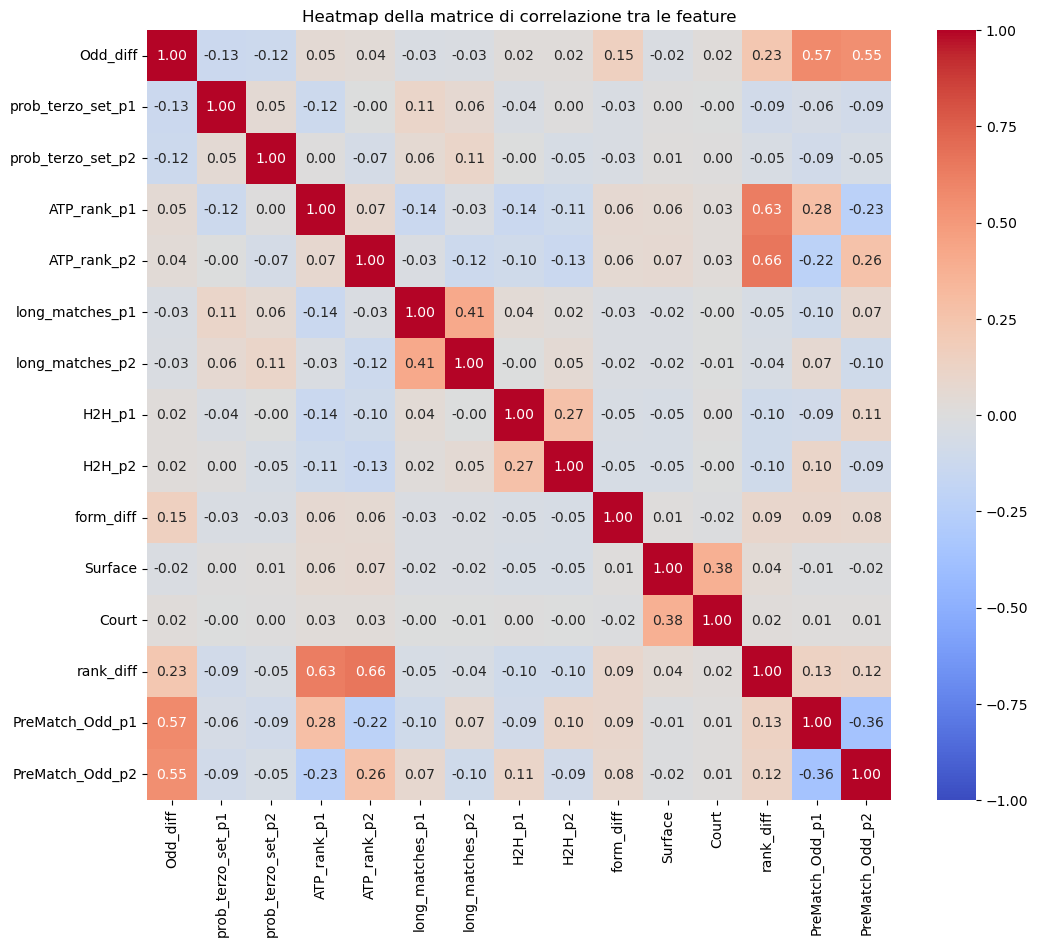

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcolo della matrice di correlazione
correlation_matrix = X.corr()

# Plot della heatmap della matrice di correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Heatmap della matrice di correlazione tra le feature")
plt.show()


# Bilanciamento classi

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

# Divisione in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y_sets, test_size=0.2, stratify=y_sets, random_state=42)

# Combina le feature e i target
data = pd.concat([X_train, y_train], axis=1)

# Separa le classi
class_0 = data[data[y_train.name] == 0]
class_1 = data[data[y_train.name] == 1]

# Sovracampiona la classe minoritaria
class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)

# Combina i campioni bilanciati
data_balanced = pd.concat([class_0, class_1_upsampled])

# Separazione in feature e target
X_train_balanced = data_balanced.drop(columns=[y_train.name])
y_train_balanced = data_balanced[y_train.name]

print("\nDistribuzione delle classi dopo il sovracampionamento:")
print(y_train_balanced.value_counts())

# Controlla i tipi di dato delle colonne
print("\nTipi di dato delle colonne:")
print(X.dtypes)

# Identifica le colonne non numeriche
non_numeric_columns = X.select_dtypes(include=['object']).columns
print("\nColonne non numeriche:", non_numeric_columns)

# Codifica delle colonne non numeriche con LabelEncoder
for col in non_numeric_columns:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])  # Utilizza .loc per evitare il warning



Distribuzione delle classi dopo il sovracampionamento:
target_sets
0    20100
1    20100
Name: count, dtype: int64

Tipi di dato delle colonne:
Odd_diff             float64
prob_terzo_set_p1    float64
prob_terzo_set_p2    float64
ATP_rank_p1          float64
ATP_rank_p2          float64
long_matches_p1      float64
long_matches_p2      float64
H2H_p1                 int64
H2H_p2                 int64
form_diff            float64
Surface                int64
Court                  int64
rank_diff            float64
PreMatch_Odd_p1      float64
PreMatch_Odd_p2      float64
dtype: object

Colonne non numeriche: Index([], dtype='object')


# Sampling per addestramento di prova

In [72]:
from sklearn.preprocessing import StandardScaler

# Crea un campione più piccolo dai dati bilanciati
sample_size = 2000  # Dimensione del sample
data_sample = data_balanced.sample(n=sample_size, random_state=42)

# Separazione in feature e target per il campione
X_train_sample = data_sample.drop(columns=[y_train.name])
y_train_sample = data_sample[y_train.name]

print("\nDistribuzione del campione bilanciato:")
print(y_train_sample.value_counts())

# Verifica le dimensioni del campione
print(f"\nDimensioni del campione: {X_train_sample.shape}, {y_train_sample.shape}")

#Scalatura dati
scaler = StandardScaler()
X_train_sample = scaler.fit_transform(X_train_sample)
X_test = scaler.transform(X_test)



Distribuzione del campione bilanciato:
target_sets
1    1008
0     992
Name: count, dtype: int64

Dimensioni del campione: (2000, 15), (2000,)


## Addestramento

In [73]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression



# Modelli da testare
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='saga', max_iter=5000, random_state=42),
    "SVM": SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
}

# Funzione per addestrare i modelli
def train_models(models, X_train_balanced, y_train_balanced):
    trained_models = {}
    for model_name, model in models.items():
        print(f"\nAddestramento del modello: {model_name}")
        model.fit(X_train_balanced, y_train_balanced)
        trained_models[model_name] = model
    print("\nAddestramento completato per tutti i modelli.")
    return trained_models

# Addestramento sui dati di campione
trained_models = train_models(models, X_train_balanced, y_train_balanced)



Addestramento del modello: Logistic Regression

Addestramento del modello: SVM

Addestramento del modello: Random Forest

Addestramento del modello: XGBoost


c:\Users\kikop\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Addestramento del modello: LightGBM
[LightGBM] [Info] Number of positive: 20100, number of negative: 20100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 40200, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Addestramento del modello: KNN

Addestramento del modello: Decision Tree

Addestramento del modello: Extra Trees

Addestramento completato per tutti i modelli.


# Valutazione Modelli


Valutazione del modello: Logistic Regression


c:\Users\kikop\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


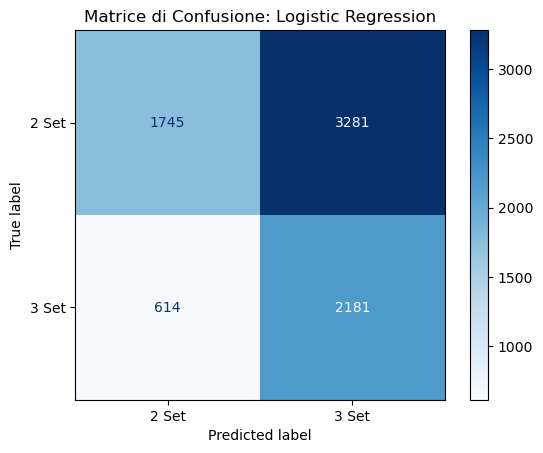


Report di classificazione per Logistic Regression:
              precision    recall  f1-score   support

       2 Set       0.74      0.35      0.47      5026
       3 Set       0.40      0.78      0.53      2795

    accuracy                           0.50      7821
   macro avg       0.57      0.56      0.50      7821
weighted avg       0.62      0.50      0.49      7821


Valutazione del modello: SVM


c:\Users\kikop\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


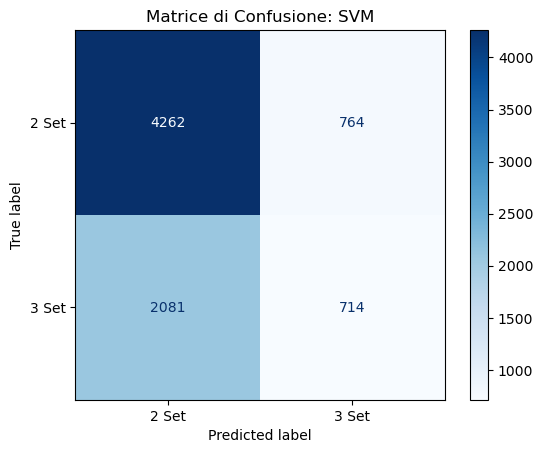


Report di classificazione per SVM:
              precision    recall  f1-score   support

       2 Set       0.67      0.85      0.75      5026
       3 Set       0.48      0.26      0.33      2795

    accuracy                           0.64      7821
   macro avg       0.58      0.55      0.54      7821
weighted avg       0.60      0.64      0.60      7821


Valutazione del modello: Random Forest


c:\Users\kikop\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


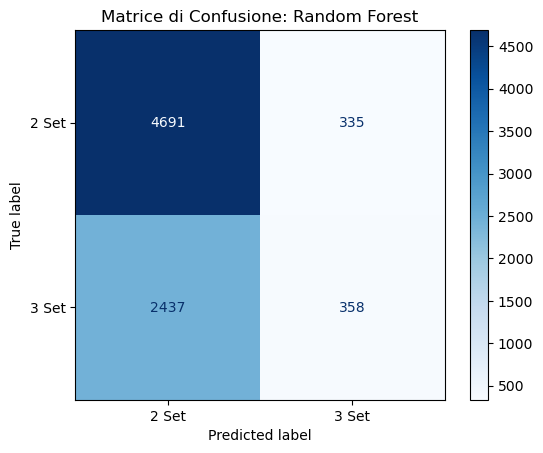


Report di classificazione per Random Forest:
              precision    recall  f1-score   support

       2 Set       0.66      0.93      0.77      5026
       3 Set       0.52      0.13      0.21      2795

    accuracy                           0.65      7821
   macro avg       0.59      0.53      0.49      7821
weighted avg       0.61      0.65      0.57      7821


Valutazione del modello: XGBoost


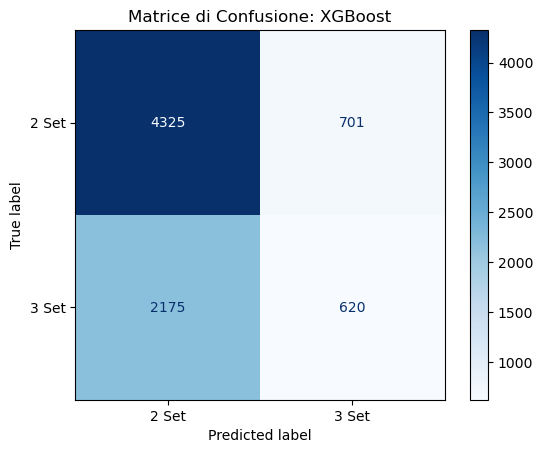


Report di classificazione per XGBoost:
              precision    recall  f1-score   support

       2 Set       0.67      0.86      0.75      5026
       3 Set       0.47      0.22      0.30      2795

    accuracy                           0.63      7821
   macro avg       0.57      0.54      0.53      7821
weighted avg       0.60      0.63      0.59      7821


Valutazione del modello: LightGBM


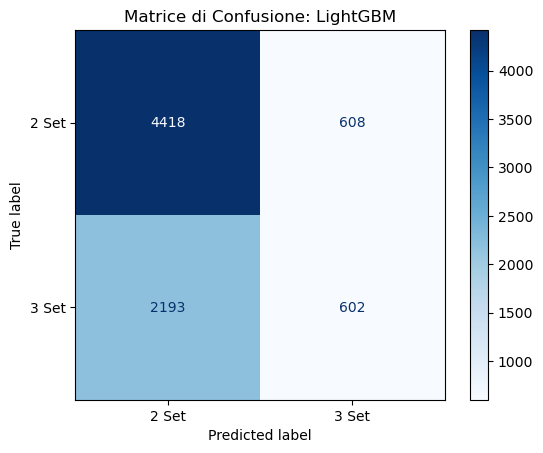


Report di classificazione per LightGBM:
              precision    recall  f1-score   support

       2 Set       0.67      0.88      0.76      5026
       3 Set       0.50      0.22      0.30      2795

    accuracy                           0.64      7821
   macro avg       0.58      0.55      0.53      7821
weighted avg       0.61      0.64      0.60      7821


Valutazione del modello: KNN


c:\Users\kikop\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


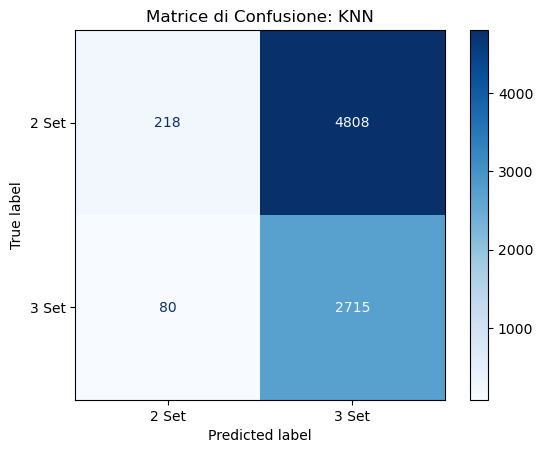


Report di classificazione per KNN:
              precision    recall  f1-score   support

       2 Set       0.73      0.04      0.08      5026
       3 Set       0.36      0.97      0.53      2795

    accuracy                           0.38      7821
   macro avg       0.55      0.51      0.30      7821
weighted avg       0.60      0.38      0.24      7821


Valutazione del modello: Decision Tree


c:\Users\kikop\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


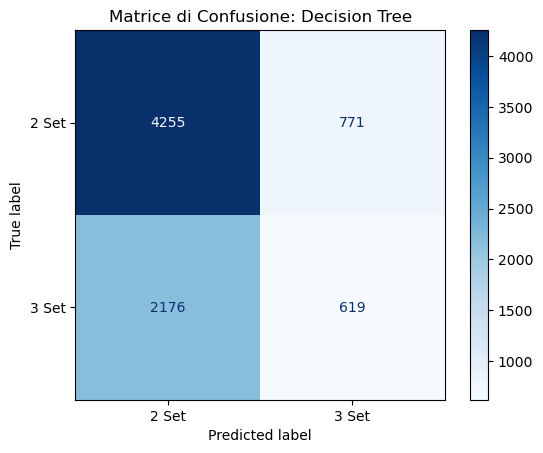


Report di classificazione per Decision Tree:
              precision    recall  f1-score   support

       2 Set       0.66      0.85      0.74      5026
       3 Set       0.45      0.22      0.30      2795

    accuracy                           0.62      7821
   macro avg       0.55      0.53      0.52      7821
weighted avg       0.58      0.62      0.58      7821


Valutazione del modello: Extra Trees


c:\Users\kikop\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


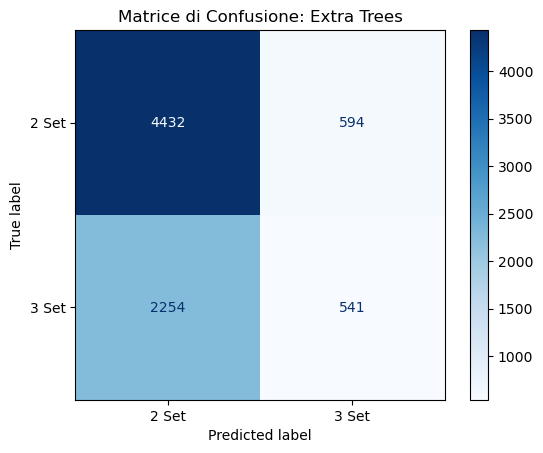


Report di classificazione per Extra Trees:
              precision    recall  f1-score   support

       2 Set       0.66      0.88      0.76      5026
       3 Set       0.48      0.19      0.28      2795

    accuracy                           0.64      7821
   macro avg       0.57      0.54      0.52      7821
weighted avg       0.60      0.64      0.58      7821


Risultati per tutti i modelli:

Modello: Logistic Regression
Confusion Matrix:
[[1745 3281]
 [ 614 2181]]
Classification Report:
              precision    recall  f1-score   support

       2 Set       0.74      0.35      0.47      5026
       3 Set       0.40      0.78      0.53      2795

    accuracy                           0.50      7821
   macro avg       0.57      0.56      0.50      7821
weighted avg       0.62      0.50      0.49      7821


Modello: SVM
Confusion Matrix:
[[4262  764]
 [2081  714]]
Classification Report:
              precision    recall  f1-score   support

       2 Set       0.67      0.85  

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Funzione per valutare i modelli
def evaluate_models(trained_models, X_test, y_test):
    results = {}
    for model_name, model in trained_models.items():
        print(f"\nValutazione del modello: {model_name}")
        
        # Predizione
        y_pred = model.predict(X_test)
        
        # Matrice di confusione
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["2 Set", "3 Set"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Matrice di Confusione: {model_name}")
        plt.show()
        
        # Report di classificazione
        report = classification_report(y_test, y_pred, target_names=["2 Set", "3 Set"])
        print(f"\nReport di classificazione per {model_name}:\n{report}")
        
        # Salva i risultati
        results[model_name] = {
            "confusion_matrix": cm,
            "classification_report": report
        }
    
    # Stampa i risultati finali
    print("\nRisultati per tutti i modelli:")
    for model_name, metrics in results.items():
        print(f"\nModello: {model_name}")
        print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
        print(f"Classification Report:\n{metrics['classification_report']}")
    
    return results

# Valutazione sui dati di test
results = evaluate_models(trained_models, X_test, y_test)
